In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [ ]:
train_dir = '/kaggle/input/dataset/train'
val_dir = '/kaggle/input/dataset/val'
test_dir = '/kaggle/input/dataset/test'


In [ ]:
# Image size and batch size
image_size = (224, 224)
batch_size = 32

# Data augmentation and preprocessing for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data preprocessing for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for training, validation, and test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # binary because you're doing binary classification
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [ ]:
# Load the previously saved SimCLR model
model = tf.keras.models.load_model('/kaggle/input/new-model/simclr_model_best.keras')

# Remove the last layer and replace it with a new one suited for binary classification
x = model.layers[-2].output  # Get the output of the second-to-last layer
output = layers.Dense(1, activation='sigmoid', name='output_dense')(x)  # Add a sigmoid output layer with a unique name

# Create the new model
model = models.Model(inputs=model.input, outputs=output)

# Compile the model with binary crossentropy loss and an Adam optimizer
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Learning rate reduction callback
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Model checkpoint callback (saving the best model during training)
checkpoint = ModelCheckpoint(
    '/kaggle/working/simclr_model_best.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False
)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[lr_reduction, checkpoint],  # Callbacks for model saving and learning rate adjustment
    verbose=2
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731414678.685050     113 service.cc:145] XLA service 0x79b180003d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731414678.685101     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731414708.436094     113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_36', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1731414708.484372     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the


Epoch 1: val_loss improved from inf to 0.33858, saving model to /kaggle/working/simclr_model_best.keras
155/155 - 276s - 2s/step - accuracy: 0.5736 - loss: 0.7978 - val_accuracy: 0.8500 - val_loss: 0.3386 - learning_rate: 1.0000e-05
Epoch 2/20

Epoch 2: val_loss improved from 0.33858 to 0.28303, saving model to /kaggle/working/simclr_model_best.keras
155/155 - 119s - 768ms/step - accuracy: 0.8577 - loss: 0.3283 - val_accuracy: 0.8583 - val_loss: 0.2830 - learning_rate: 1.0000e-05
Epoch 3/20

Epoch 3: val_loss did not improve from 0.28303
155/155 - 120s - 772ms/step - accuracy: 0.9254 - loss: 0.2188 - val_accuracy: 0.8750 - val_loss: 0.2858 - learning_rate: 1.0000e-05
Epoch 4/20

Epoch 4: val_loss did not improve from 0.28303
155/155 - 142s - 919ms/step - accuracy: 0.9416 - loss: 0.1675 - val_accuracy: 0.8750 - val_loss: 0.3092 - learning_rate: 1.0000e-05
Epoch 5/20

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 5: val_loss did not improve from 0.28

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9454 - loss: 0.1980
Test Loss: 0.23418262600898743
Test Accuracy: 0.9365079402923584


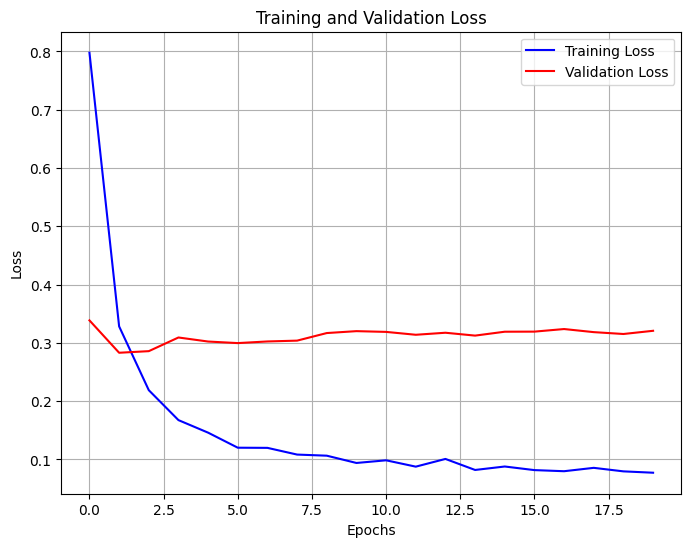

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Save the final model
model.save('/kaggle/working/simclr_model_final.keras')
